In [1]:
# Mount "My Drive" into /content/drive
from google.colab import drive

google_drive_dir = "Final_project"  # @param
#bml-notebooks/
drive.mount('/content/drive')

mount_point = "/content/drive/My Drive/{}".format(google_drive_dir)

# Change the root directory to your mount_point
% cd '$mount_point'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Final_project


# Downgrade opencv

In [2]:
import cv2
if cv2.__version__[0] == '4':
    !pip uninstall opencv-python -y
    #downgrade OpenCV a bit since some none-free features are not avilable
    !pip install opencv-contrib-python==3.4.2.17 --force-reinstall

# <span style="color: royalblue;">Load Data</span>
Load the image data with labels.

In [3]:
from src.loadData import loadFer2013
from keras.utils import to_categorical

In [4]:
X_train,X_val,X_test,y_train,y_val,y_test = loadFer2013('fer2013/icml_face_data.csv')

y_train_onehot = to_categorical(y_train)
y_val_onehot = to_categorical(y_val)
y_test_onehot = to_categorical(y_test)

/content/drive/My Drive/Final_project/src/loadData.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['emotion'][data['emotion']>1]-=1


In [ ]:
y_train_onehot.shape, y_val_onehot.shape, y_test_onehot.shape

((28709, 6), (3589, 6), (3589, 6))

In [ ]:
X_train.shape, y_train.shape

((28709, 48, 48), (28709,))

In [ ]:
emotions = {0: 'Angry', 1:'Fear', 2: 'Happy', 3: 'Sad', 4: 'Surprise', 5: 'Neutral'}

In [ ]:
class_names = list(emotions.values())
class_names

['Angry', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Extract features

In [ ]:
from src.extractFeatures import *

In [ ]:
X_descriptors_train = extract_sift_features(X_train)
X_descriptors_val = extract_sift_features(X_val)
for i in range(10):
    print('Image {} has {} descriptors'.format(i, len(X_descriptors_train[i])))

Image 0 has 24 descriptors
Image 1 has 36 descriptors
Image 2 has 25 descriptors
Image 3 has 26 descriptors
Image 4 has 27 descriptors
Image 5 has 25 descriptors
Image 6 has 23 descriptors
Image 7 has 20 descriptors
Image 8 has 25 descriptors
Image 9 has 26 descriptors


In [ ]:
import time
num_clusters = 150
X_descriptors = X_descriptors_train+X_descriptors_val
print(len(X_descriptors))
st = time.time()
bow_dict = create_BoWSIFTfeature(X_descriptors,num_clusters)
en = time.time()
print("time",en-st)
X_features = create_features_bow(X_descriptors, bow_dict, num_clusters)


32298
Done load available result
time 0.0046117305755615234


In [ ]:
len(X_features)

32298

#PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pct = pca.fit_transform(X_features)

In [ ]:
from sklearn.decomposition import KernelPCA
kpca = KernelPCA(n_components=2,kernel="rbf", gamma=0.5) #“linear” | “poly” | “rbf” | “sigmoid” | “cosine” | “precomputed”
data_kpca = kpca.fit_transform(X_features)

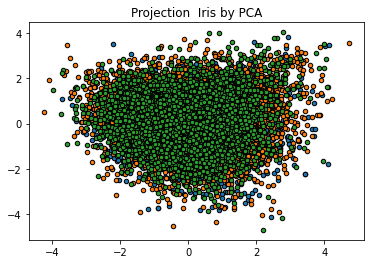

In [ ]:
import itertools
import matplotlib.pyplot as plt

colors = itertools.cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
plt.scatter(pct[y_label==0, 0], pct[y_label==0, 1], c=next(colors), s=20, edgecolor='k')
# plt.scatter(pct[y_label==1, 0], pct[y_label==1, 1], c=next(colors), s=20, edgecolor='k')
plt.scatter(pct[y_label==2, 0], pct[y_label==2, 1], c=next(colors), s=20, edgecolor='k')
# plt.scatter(pct[y_label==3, 0], pct[y_label==3, 1], c=next(colors), s=20, edgecolor='k')
# plt.scatter(pct[y_label==4, 0], pct[y_label==4, 1], c=next(colors), s=20, edgecolor='k')
plt.scatter(pct[y_label==5, 0], pct[y_label==5, 1], c=next(colors), s=20, edgecolor='k')

plt.title("Projection  Iris by PCA")
plt.show()

# Classification

In [ ]:
from sklearn.linear_model import LogisticRegression

y_label = np.hstack((y_train,y_val))
y_label.shape

(32298,)

#GridSearch

In [ ]:
from sklearn.model_selection import GridSearchCV
parameters = {'C':np.logspace(-10, 1, 100)}
logis_model = LogisticRegression(max_iter=1000)
clf = GridSearchCV(logis_model, parameters)
clf.fit(X_features, y_label)

KeyboardInterrupt: ignored

In [ ]:
import pickle
pickle.dump(clf, open('saved_model/sift68_logis_copt.pkl', 'wb'))

In [ ]:
import pickle
clf = pickle.load(open('saved_model/sift150_logis.pkl','rb'))

In [ ]:
clf.best_params_

{'C': 0.0007742636826811262}

In [ ]:
clf.score(X_features, y_label)

0.25097529258777634

In [ ]:
clf.best_estimator_.score(X_features, y_label)

0.25097529258777634

In [ ]:
model = LogisticRegression(C=0.00077,max_iter=3000,verbose=0)

st= time.time()
model.fit(X_features, y_label)
print(time.time()-st)
model.score(X_features, y_label)

3.7949795722961426


0.2511610626044956

#Evaluation

In [ ]:
import pickle

num_clusters = 150
bow_dict = pickle.load(open('BoW_data/bow_dict_{}.pkl'.format(num_clusters), 'rb'))

X_descriptors_test = extract_sift_features(X_test)
X_features_test = create_features_bow(X_descriptors_test, bow_dict,num_clusters )
y_pred = model.predict(X_features_test)

print(model.score(X_features_test,y_test))

0.2521593758707161


# Visual

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f350bbd8ef0>)

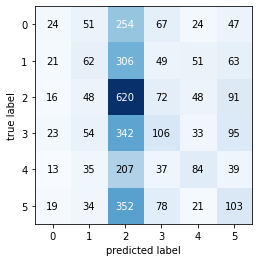

In [ ]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

plot_confusion_matrix(confusion_matrix(y_test,y_pred))

In [ ]:
from sklearn.metrics import classification_report
from src.visualization import plot_classification_report

clf_report = classification_report(y_test, y_pred, digits=4)
print(clf_report)

              precision    recall  f1-score   support

           0     0.1646    0.0278    0.0476       467
           1     0.2059    0.1014    0.1359       552
           2     0.2887    0.7173    0.4117       895
           3     0.2727    0.1654    0.2059       653
           4     0.3219    0.1807    0.2315       415
           5     0.2364    0.1499    0.1835       607

    accuracy                         0.2744      3589
   macro avg     0.2483    0.2238    0.2027      3589
weighted avg     0.2519    0.2744    0.2250      3589



In [ ]:
import pandas as pd
df = pd.DataFrame(classification_report(y_test, y_pred, digits=1,output_dict=True)).T

df['support'] = df.support.apply(int)

df.style.background_gradient(cmap='viridis',
                             subset=pd.IndexSlice['0':'6', :'f1-score'])

,precision,recall,f1-score,support
0,0.206897,0.051392,0.082333,467
1,0.218310,0.112319,0.148325,552
2,0.297934,0.692737,0.416667,895
3,0.259169,0.162328,0.199623,653
4,0.321839,0.202410,0.248521,415
5,0.235160,0.169687,0.197129,607
accuracy,0.278351,0.278351,0.278351,0
macro avg,0.256551,0.231812,0.215433,3589
weighted avg,0.258936,0.278351,0.235829,3589


#SIFT visual

In [ ]:
X_train.shape

(28709, 48, 48)

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def getSIFT(X):
    if X.dtype != np.uint8:
        X = X.astype(np.uint8)
    
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(X, None)
    return kp,des

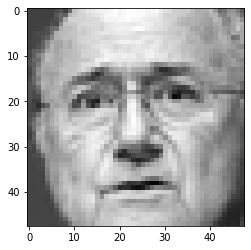

In [6]:
import cv2

img1 = X_train[5].astype(np.uint8)
# img1 = np.expand_dims(img,axis=[-1])
img1.shape
plt.imshow(img1,cmap='gray')

25


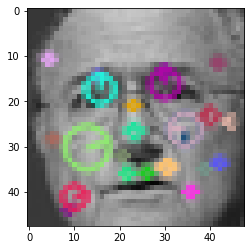

In [7]:
kp,des = getSIFT(img1)
print(len(kp))
img1=cv2.drawKeypoints(img1,kp,img1,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img1,cmap='gray')
plt.show()

In [ ]:
des = extract_sift_features(X_train[:2])

In [ ]:
des[0].shape

(24, 128)

In [ ]:
X_train[:2].shape

(2, 48, 48)

In [ ]:
y_label[3]

3

In [ ]:
emotions[3]

'Sad'